In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
from operator import attrgetter
from ordered_set import OrderedSet
# if you use conda run this in your terminal: conda install -c conda-forge ordered-set
import gurobipy as gb

In [2]:
# local files
from customer import Customer
from locker_customer import LockerCustomer
from door_to_door_customer import DoorToDoorCustomer
from location import Location
from store import *
from vehicle import Vehicle
from vehicle_type import VehicleType

In [3]:
# input
custom_setup = False
C = 15
L = 2

map_size = 100
ratio_locker_customers = 0.3

In [4]:
def get_nearest_store(stores, location):
    min_distance = float("inf")
    nearest_store = stores[0]
    for store in stores:
        distance = location.euclidean_distance(store.location)
        if distance < min_distance:
            min_distance = distance
            nearest_store = store
    return nearest_store

In [5]:
# generate data
if custom_setup:
    C = 8
    L = 2
    stores = []
    stores.append(Store(0, Location(60, 50), capacity=float("inf"), is_warehouse=True))
    stores.append(Store(1, Location(30, 50), capacity=math.ceil(0.8 * C / L)))
    stores.append(Store(2, Location(50, 20), capacity=math.ceil(0.8 * C / L)))

    customers = []
    customers.append(LockerCustomer(0, 0, Location(10, 28), stores[1]))
    customers.append(DoorToDoorCustomer(1, 0, Location(20, 40)))
    customers.append(DoorToDoorCustomer(2, 1, Location(15, 70)))
    customers.append(DoorToDoorCustomer(3, 2, Location(30, 70)))
    customers.append(DoorToDoorCustomer(4, 3, Location(80, 60)))
    customers.append(LockerCustomer(5, 1, Location(70, 40), stores[0]))
    customers.append(DoorToDoorCustomer(6, 4, Location(90, 50)))
    customers.append(LockerCustomer(7, 2, Location(40, 15), stores[2]))
else:
    stores = []
    stores.append(Store(0, Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=float("inf"), is_warehouse=True))
    for l in range(L):
        stores.append(Store(l+1, Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=math.ceil(0.8 * C / L)))

    customers = []
    counter_locker_customer = 0
    counter_door_to_door_customer = 0
    for c in range(C):
        location = Location(random.randint(0, map_size), random.randint(0, map_size))
        if random.random() < ratio_locker_customers:
            # customer locker
            customers.append(LockerCustomer(c, counter_locker_customer, location, get_nearest_store(stores, location)))
            counter_locker_customer += 1
        else:
            # door to door customer
            customers.append(DoorToDoorCustomer(c, counter_door_to_door_customer, location))
            counter_door_to_door_customer += 1

In [6]:
# create sets
C_L = list(filter(lambda customer: type(customer) == LockerCustomer, customers))
C_D = list(filter(lambda customer: type(customer) == DoorToDoorCustomer, customers))
lockers = list(filter(lambda store: not store.is_warehouse, stores))

sum_W_l = 0
for store in stores:
    if not store.is_warehouse:
        sum_W_l += store.capacity

# define all the vehicles
if custom_setup:
    vehicles = []
    vehicles.append(Vehicle(0, VehicleType.LOCKER_SUPPLY, stores[0], math.ceil(0.8 * sum_W_l)))
    vehicles.append(Vehicle(1, VehicleType.PF, stores[0], math.ceil(0.5 * len(C_D))))
    vehicles.append(Vehicle(2, VehicleType.LF, stores[1], math.ceil(0.6 * stores[1].capacity)))
    vehicles.append(Vehicle(3, VehicleType.LF, stores[2], math.ceil(0.6 * stores[2].capacity)))
else:
    vehicles = []
    for store in stores:
        if store.is_warehouse:
            vehicles.append(Vehicle(0, VehicleType.LOCKER_SUPPLY, store, math.ceil(0.8 * sum_W_l)))
            vehicles.append(Vehicle(1, VehicleType.PF, store, math.ceil(0.5 * len(C_D))))
        else:
            vehicles.append(Vehicle(store.index+1, VehicleType.LF, store, math.ceil(0.6 * store.capacity)))

In [7]:
# define some np.array to plot the map
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
L_location = np.array([[0,0]])
W_location = np.array([[0,0]])

for store in stores:
    if store.is_warehouse:
        W_location = np.vstack([W_location, [store.location.x, store.location.y]])
    else:
        L_location = np.vstack([L_location, [store.location.x, store.location.y]])
for cd in C_D:
    CD_location = np.vstack([CD_location, [cd.location.x, cd.location.y]])
for cl in C_L:
    CL_location = np.vstack([CL_location, [cl.location.x, cl.location.y]])

CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)
L_location = np.delete(L_location, 0, 0)
W_location = np.delete(W_location, 0, 0)

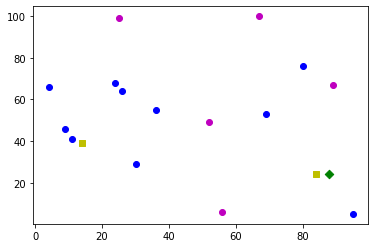

In [8]:
# plot the map
plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

In [9]:
#calcolo la matrice delle distanze:

all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + C_D + C_L

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)


             W         L1         L2        CD0        CD1        CD2  \
W     0.000000   4.000000  75.504967  52.611786  82.006097  77.665951   
L1    4.000000   0.000000  71.589105  52.153619  78.160092  74.404301   
L2   75.504967  71.589105   0.000000  75.663730   8.602325  30.675723   
CD0  52.611786  52.153619  75.663730   0.000000  77.077883  56.568542   
CD1  82.006097  78.160092   8.602325  77.077883   0.000000  26.627054   
CD2  77.665951  74.404301  30.675723  56.568542  26.627054   0.000000   
CD3  78.854296  74.953319   3.605551  77.369245   5.385165  29.966648   
CD4  73.783467  70.455660  27.730849  55.317267  24.758837   4.472136   
CD5  34.669872  32.649655  56.753854  25.495098  60.406953  47.434165   
CD6  60.539243  57.140179  27.202941  48.754487  28.460499  17.691806   
CD7  20.248457  21.954498  87.846457  72.567210  95.273291  94.921020   
CD8  93.914855  90.354856  28.792360  76.655072  20.615528  20.099751   
CD9  58.215118  54.230987  18.867962  68.622154  27

In [10]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=[stores[0]] + C_D, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=[stores[0]] + C_D, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+C_D, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + C_D, axis=0)
print(LF_distances_matrix)

            W         L1         L2
W    0.000000   4.000000  75.504967
L1   4.000000   0.000000  71.589105
L2  75.504967  71.589105   0.000000
             W        CD0        CD1        CD2        CD3        CD4  \
W     0.000000  52.611786  82.006097  77.665951  78.854296  73.783467   
CD0  52.611786   0.000000  77.077883  56.568542  77.369245  55.317267   
CD1  82.006097  77.077883   0.000000  26.627054   5.385165  24.758837   
CD2  77.665951  56.568542  26.627054   0.000000  29.966648   4.472136   
CD3  78.854296  77.369245   5.385165  29.966648   0.000000  27.459060   
CD4  73.783467  55.317267  24.758837   4.472136  27.459060   0.000000   
CD5  34.669872  25.495098  60.406953  47.434165  59.228372  44.384682   
CD6  60.539243  48.754487  28.460499  17.691806  28.653098  13.453624   
CD7  20.248457  72.567210  95.273291  94.921020  91.389277  90.785461   
CD8  93.914855  76.655072  20.615528  20.099751  25.961510  22.090722   
CD9  58.215118  68.622154  27.018512  39.458839  22.4

In [11]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)


            W         L1         L2
W    0.000000   3.000000  56.628725
L1   3.000000   0.000000  53.691829
L2  56.628725  53.691829   0.000000
             W        CD0        CD1        CD2        CD3        CD4  \
W     0.000000  52.611786  82.006097  77.665951  78.854296  73.783467   
CD0  52.611786   0.000000  77.077883  56.568542  77.369245  55.317267   
CD1  82.006097  77.077883   0.000000  26.627054   5.385165  24.758837   
CD2  77.665951  56.568542  26.627054   0.000000  29.966648   4.472136   
CD3  78.854296  77.369245   5.385165  29.966648   0.000000  27.459060   
CD4  73.783467  55.317267  24.758837   4.472136  27.459060   0.000000   
CD5  34.669872  25.495098  60.406953  47.434165  59.228372  44.384682   
CD6  60.539243  48.754487  28.460499  17.691806  28.653098  13.453624   
CD7  20.248457  72.567210  95.273291  94.921020  91.389277  90.785461   
CD8  93.914855  76.655072  20.615528  20.099751  25.961510  22.090722   
CD9  58.215118  68.622154  27.018512  39.458839  22.4

In [12]:

LF_delivery_cost_multidim = np.zeros((L,len(C_D)+1,len(C_D)+1))

for i in range(L):
    l = [0]
    l[0]=lockers[i]
    ls = LF_delivery_cost.filter(items=l+C_D,axis=1)
    ls = ls.filter(items=l+C_D,axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1+len(C_D)):
        for k in range(1+len(C_D)):
            LF_delivery_cost_multidim[i][j][k]=lt[j][k]


            L1        CD0        CD1        CD2        CD3        CD4  \
L1    0.000000  44.330576  66.436078  63.243656  63.710321  59.887311   
CD0  44.330576   0.000000  65.516200  48.083261  65.763858  47.019677   
CD1  66.436078  65.516200   0.000000  22.632996   4.577390  21.045011   
CD2  63.243656  48.083261  22.632996   0.000000  25.471651   3.801316   
CD3  63.710321  65.763858   4.577390  25.471651   0.000000  23.340201   
CD4  59.887311  47.019677  21.045011   3.801316  23.340201   0.000000   
CD5  27.752207  21.670833  51.345910  40.319040  50.344116  37.726980   
CD6  48.569152  41.441314  24.191424  15.038035  24.355133  11.435580   
CD7  18.661324  61.682129  80.982297  80.682867  77.680886  77.167642   
CD8  76.801628  65.156811  17.523199  17.084789  22.067283  18.777114   
CD9  46.096339  58.328831  22.965735  33.540013  19.101374  29.943655   

           CD5        CD6        CD7        CD8        CD9  
L1   27.752207  48.569152  18.661324  76.801628  46.096339  
C

In [13]:

col_ind = []
d_ak_k=[]
index_close_locker = []
min_value = []
Sk_def=[]
OC = []
position_sk = []
position_cl = []
pck = np.array([])
locker_where_oc_goes=[]
#compensation

compensation_matrix= dist_matrix.filter(items=stores+C_D,axis=1)
compensation_matrix=compensation_matrix.filter(items=stores+C_D,axis=0)


distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)


closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
min_value_col = distance_matrix_customer_locker_store.min()

for i in range(len(closest_store_to_CL)):
    index_close_locker.append(str(closest_store_to_CL[i]))
    min_value.append(min_value_col[i])

for i in range(len(C_L)):
    col_ind.append("D_"+str(index_close_locker[i])+"_"+str(C_L[i].index))


d_ak_k = pd.DataFrame(min_value, index=col_ind)


pre_d_c_k = dist_matrix.filter(items=C_D,axis=0)
pre_d_c_k = pre_d_c_k.filter(items=C_L,axis=1)

d_ak_c = pd.DataFrame()

# insert d_c_k
for cl in C_L:
    # Using DataFrame.insert() to add a column
    store = cl.store
    array = []
    for cd in C_D:
        distance = store.location.euclidean_distance(cd.location)
        array.append(distance)
    d_ak_c.insert(len(d_ak_c.columns), store, array, True)


d_c_k = dist_matrix.filter(items=C_D,axis=0)
d_c_k = d_c_k.filter(items=C_L,axis=1)

sum_dck_dakc = d_ak_c.to_numpy()+d_c_k.to_numpy()

def find_Sk(cd,cl):
    S_K_i = []
    if sum_dck_dakc[cl][cd]<=1.5*d_ak_k.to_numpy()[cl]:
        S_K_i.append('Cd'+str(cd))
    return S_K_i


for cl in range(len(C_L)):
    for cd in range(len(C_D)):
        if sum_dck_dakc[cd][cl]<=1.5*d_ak_k.to_numpy()[cl]:
            OC.append('Cl'+str(cl))
            Sk_def.append('CD'+str(cd))
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl]))

def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

OC_unique = unique(OC)

Sk = unique(Sk_def)
Sk=sorted(Sk, key=lambda x: int("".join([i for i in x if i.isdigit()])))


S_k = []

for cd in C_D:
    for s in range(len(Sk)):
        if str(cd) == Sk[s]:
            S_k.append(cd)



index_of_cl_associated_to_closest_locker =[]
for i in range(len(OC_unique)):
    index_of_cl_associated_to_closest_locker.append(OC_unique[i]+'->'+locker_where_oc_goes[OC.index(OC_unique[i])])


big_matrix= np.zeros((len(C_D),len(C_L)))
big_matrix=pd.DataFrame(big_matrix, index=C_D, columns=C_L)

for i in range(len(position_sk)):
    big_matrix.values[position_sk[i]][position_cl[i]]=d_ak_c.values[position_sk[i]][position_cl[i]]


OC = []
for i in C_L:
    is_all_null = True
    for j in range(len(C_D)):
        if big_matrix.values[j][i.locker_customer_index] != 0:
            is_all_null = False
            OC.append(i)
OC = list(OrderedSet(OC))

filter_cd_sk = []
for cd in C_D:
    for s in range(len(position_sk)):
        if cd.door_to_door_customer_index == position_sk[s]:
            filter_cd_sk.append(cd)

d_cd_oc=big_matrix.filter(items=OC,axis=1)
d_ak_c=d_cd_oc.filter(items=S_k,axis=0)
d_ak_c.columns= index_of_cl_associated_to_closest_locker
print(d_ak_c)
d_ak_c = d_ak_c.to_numpy()


pck = 0.5*d_ak_c
for c in range(len(Sk)):
    for k in range(len(OC_unique)):
        if pck[c][k]==0:
            pck[c][k]=100000

print(pck)

lockers_wrt_their_oc_matrix = dist_matrix.filter(items=OC,axis=1)
lockers_wrt_their_oc_matrix = lockers_wrt_their_oc_matrix.filter(items=stores,axis=0)

lockers_wrt_their_oc = lockers_wrt_their_oc_matrix.idxmin()

lockers_wrt_their_oc_array =[]
for i in range(len(OC_unique)):
    lockers_wrt_their_oc_array.append(lockers_wrt_their_oc[i])




        Cl0->W    Cl2->L2    Cl3->L1    Cl4->L2
CD0   0.000000   0.000000  52.153619   0.000000
CD1   0.000000   8.602325   0.000000   8.602325
CD2   0.000000  30.675723   0.000000   0.000000
CD3   0.000000   3.605551   0.000000   3.605551
CD4   0.000000  27.730849   0.000000  27.730849
CD5  34.669872   0.000000  32.649655   0.000000
CD6   0.000000  27.202941  57.140179  27.202941
CD8   0.000000  28.792360   0.000000   0.000000
CD9   0.000000  18.867962   0.000000  18.867962
[[1.00000000e+05 1.00000000e+05 2.60768096e+01 1.00000000e+05]
 [1.00000000e+05 4.30116263e+00 1.00000000e+05 4.30116263e+00]
 [1.00000000e+05 1.53378617e+01 1.00000000e+05 1.00000000e+05]
 [1.00000000e+05 1.80277564e+00 1.00000000e+05 1.80277564e+00]
 [1.00000000e+05 1.38654246e+01 1.00000000e+05 1.38654246e+01]
 [1.73349358e+01 1.00000000e+05 1.63248277e+01 1.00000000e+05]
 [1.00000000e+05 1.36014705e+01 2.85700893e+01 1.36014705e+01]
 [1.00000000e+05 1.43961800e+01 1.00000000e+05 1.00000000e+05]
 [1.00000000e+05

In [14]:
env = gb.Env(empty=True)
env.setParam("OutputFlag",0)
env.start()

single_period_problem =gb.Model()
single_period_problem.modelSense = gb.GRB.MINIMIZE #declare mimization


Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-11


In [15]:
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)

I_L = 1 + L
J_L = 1 + L

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)

# add var to the problem
x_i_j   =   single_period_problem.addVars([(i,j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.BINARY)
x_i_j_L =   single_period_problem.addVars([(i,j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.BINARY)
x_l_i_j =   single_period_problem.addVars([(l,i,j) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.BINARY)

y_i_j   =   single_period_problem.addVars([(i,j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.INTEGER)
y_i_j_L =   single_period_problem.addVars([(i,j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.INTEGER)
y_l_i_j =   single_period_problem.addVars([(l,i,j,) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.INTEGER)

z_c     =   single_period_problem.addVars([c for c in range(len(C_D))],vtype=gb.GRB.BINARY)
z_c_l   =   single_period_problem.addVars([(l,c)for c in range(len(C_D)) for l in range(L)],vtype=gb.GRB.BINARY)
z_l_L   =   single_period_problem.addVars([l for l in range(L)],vtype=gb.GRB.BINARY)

w_c_k   =   single_period_problem.addVars([(c,k)for k in range(len(OC_unique)) for c in range(len(Sk))],vtype=gb.GRB.BINARY, name="w_c_k")

In [16]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstr( z_c[c] + gb.quicksum(w_c_k[s,k] for s in range(len(Sk)) for k in range(len(OC_unique))
                                                          if C_D[c] == filter_cd_sk[s]) + gb.quicksum(z_c_l[l,c] for l in range(L)) == 1)
# constraint eq. 3
for k in range(len(OC_unique)):
    single_period_problem.addConstr( gb.quicksum(w_c_k[s_k,k] for s_k in range(len(Sk))) <= 1)

# constraint eq. 4
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum(cl.package_demand for cl in l.find_associated_CL(customers, stores))
        +
        gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                    if lockers[l.index-1] == lockers_wrt_their_oc_array[k] )+
        gb.quicksum(C_D[cd].package_demand*z_c_l[l.index-1,cd] for cd in range(len(C_D)))
        <= l.capacity * z_l_L[l.index-1]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[i+1,j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[j,i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )



# constraint eq. 6
single_period_problem.addConstr(
    gb.quicksum( x_i_j[0,j+1] for j in range(len(C_D)))
    - gb.quicksum( x_i_j[j+1,0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( y_i_j[j,i+1] for j in range(1+len(C_D)))
        - gb.quicksum( y_i_j[i+1,j] for j in range(1+len(C_D)))
        == C_D[i].package_demand*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstr(
    gb.quicksum( y_i_j[j+1,0] for j in range(len(C_D)))
    - gb.quicksum( y_i_j[0,j+1] for j in range(len(C_D)))
    == - gb.quicksum( C_D[i].package_demand*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstr(
            y_i_j[i,j]
            <= vehicles[1].capacity * x_i_j[i,j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstr(
        y_i_j[i+1,0]
        == 0
    )

# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[i+1,j] for j in range(1 + L))
        == z_l_L[i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[j,i+1] for j in range(1 + L))
        == z_l_L[i]
    )



# constraint eq. 12
single_period_problem.addConstr(
    gb.quicksum( x_i_j_L[0,j+1] for j in range(L))
    - gb.quicksum( x_i_j_L[j+1,0] for j in range(L))
    == 0
)

# constraint eq. 13
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum( y_i_j_L[j,l.index] for j in range(1+L))
        - gb.quicksum( y_i_j_L[l.index,j] for j in range(1+L))
        ==
        gb.quicksum(cl.package_demand for cl in l.find_associated_CL(customers, stores))
        +
        gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                    if lockers[l.index-1] == lockers_wrt_their_oc_array[k] )
        + gb.quicksum(C_D[c].package_demand*z_c_l[l.index-1,c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstr(
    gb.quicksum( y_i_j_L[j+1,0] for j in range(L))
    - gb.quicksum( y_i_j_L[0,j+1] for j in range(L))
    == - gb.quicksum(
        gb.quicksum(cl.package_demand for cl in l.find_associated_CL(customers, stores))
        +
        gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                    if lockers[l.index-1] == lockers_wrt_their_oc_array[k] )
        + gb.quicksum(C_D[c].package_demand*z_c_l[l.index-1,c] for c in range(len(C_D)))
        for l in lockers
    )
)


# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstr(
            y_i_j_L[i,j]
            <= vehicles[0].capacity * x_i_j_L[i,j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstr(
        y_i_j_L[i+1,0]
        == 0
    )

# Local fleet constraints
for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,i+1,j] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,j,i+1] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 18
    single_period_problem.addConstr(
        gb.quicksum( x_l_i_j[l,0,j+1] for j in range(len(C_D)))
        - gb.quicksum( x_l_i_j[l,j+1,0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( y_l_i_j[l,j,i+1] for j in range(1+len(C_D)))
            - gb.quicksum( y_l_i_j[l,i+1,j] for j in range(1+len(C_D)))
            == C_D[i].package_demand*z_c_l[l,i]
        )

    # constraint eq. 20
    single_period_problem.addConstr(
        gb.quicksum( y_l_i_j[l,j+1,0] for j in range(len(C_D)))
        - gb.quicksum( y_l_i_j[l,0,j+1] for j in range(len(C_D)))
        == - gb.quicksum(C_D[i].package_demand*z_c_l[l,i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstr(
                y_l_i_j[l,i,j]
                <= vehicles[l+2].capacity * x_l_i_j[l,i,j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            y_l_i_j[l,i+1,0]
            == 0
        )



In [17]:
single_period_problem.setObjective(
    gb.quicksum( gb.quicksum(supply_cost.values[i][j]*x_i_j_L[i,j]   for j in range(1+L) )  for i in range(1+L))+
    gb.quicksum( gb.quicksum(pck[c][k] *w_c_k[c,k]  for c in range(len(Sk)))for k in range(len(OC_unique)))+
    gb.quicksum( gb.quicksum(PF_delivery_cost.values[i][j]*x_i_j[i,j] for j in range(1+len(C_D) ) )for i in range(1+len(C_D))) +
    gb.quicksum( gb.quicksum(gb.quicksum(LF_delivery_cost_multidim[l][i][j]*x_l_i_j[l,i,j]
                                         for j in range(1+len(C_D)))for i in range(1+len(C_D)))for l in range(L))
)

single_period_problem.optimize() #equivalent to solve() for xpress

print("---------single_period_problem.status--------")
print(single_period_problem.status)
# https://www.gurobi.com/documentation/9.5/refman/optimization_status_codes.html

print("-----------single_period_problem.Runtime-----------------")
print(single_period_problem.Runtime)
# https://www.gurobi.com/documentation/9.5/refman/runtime.html

print("-------single_period_problem.ObjVal----------")
print(single_period_problem.ObjVal)
#https://www.gurobi.com/documentation/9.5/refman/objval.html#attr:ObjVal



print( "\n", type(x_i_j), x_i_j, "\n")
print("\nSolution")
for i in range(1+len(C_D)):
    for j in range(1+len(C_D)):
        if x_i_j[i,j].x == 1:  #to access the variable value
            print("from ", i, " to ", j)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 524 rows, 812 columns and 2553 nonzeros
Model fingerprint: 0x213bcb2c
Variable types: 0 continuous, 812 integer (440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 105 rows and 122 columns
Presolve time: 0.04s
Presolved: 419 rows, 690 columns, 2188 nonzeros
Variable types: 0 continuous, 690 integer (386 binary)
Found heuristic solution: objective 1039.0907347

Root relaxation: objective 3.436591e+02, 463 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  343.65907    0   68 1039.09073  343.65907  66.9%     -    0s
H    0     0                 

xpress with custom_setup = True:
Final MIP objective                   : 1.978326002278371e+02

gurobi with custom_setup = True
Best objective 1.978326002278e+02

In [18]:
print(single_period_problem.getJSONSolution())

{ "SolutionInfo": { "Status": 2, "Runtime": 0.0563809871673584, "Work": 4.7343743332824723e-03, "ObjVal": 1.9783260022783708e+02, "ObjBound": 1.9783260022783708e+02, "ObjBoundC": 1.9783260022783708e+02, "MIPGap": 0, "IntVio": 0, "BoundVio": 0, "ConstrVio": 0, "IterCount": 105, "BarIterCount": 0, "NodeCount": 1, "SolCount": 2, "PoolObjBound": 1.9783260022783708e+02, "PoolObjVal": [ 1.9783260022783708e+02, 4.1020523345711268e+02]}, "Vars": [ { "VarName": "C0", "X": 1}, { "VarName": "C5", "X": 1}, { "VarName": "C24", "X": 1}, { "VarName": "C34", "X": 1}, { "VarName": "C36", "X": 1}, { "VarName": "C37", "X": 1}, { "VarName": "C41", "X": 1}, { "VarName": "C42", "X": 1}, { "VarName": "C45", "X": 1}, { "VarName": "C46", "X": 1}, { "VarName": "C51", "X": 1}, { "VarName": "C69", "X": 1}, { "VarName": "C85", "X": 1}, { "VarName": "C122", "X": 2}, { "VarName": "C151", "X": 1}, { "VarName": "C154", "X": 5}, { "VarName": "C158", "X": 1}, { "VarName": "C168", "X": 2}, { "VarName": "C202", "X": 1}, {

In [18]:
print(OC)
print(Sk)

[CL0, CL2, CL3, CL4]
['CD0', 'CD1', 'CD2', 'CD3', 'CD4', 'CD5', 'CD6', 'CD8', 'CD9']


In [45]:
CL_dictionary = {}

j = 0
for oc in OC:
    i = 0
    for sk in S_k:
        string = "w_c_k["+str(i)+","+str(j)+"]"
        if single_period_problem.getVarByName(string).x == 1:
            CL_dictionary[oc] = sk
        i += 1
    j += 1
print(CL_dictionary)

{CL0: CD5, CL2: CD3, CL3: CD0, CL4: CD6}


In [27]:
'''
for var in single_period_problem.getVars():
    if "w_c_k" in var.VarName:
        print(var)
'''

<gurobi.Var w_c_k[0,0] (value 0.0)>
<gurobi.Var w_c_k[1,0] (value 0.0)>
<gurobi.Var w_c_k[2,0] (value 0.0)>
<gurobi.Var w_c_k[3,0] (value 0.0)>
<gurobi.Var w_c_k[4,0] (value 0.0)>
<gurobi.Var w_c_k[5,0] (value 1.0)>
<gurobi.Var w_c_k[6,0] (value 0.0)>
<gurobi.Var w_c_k[7,0] (value 0.0)>
<gurobi.Var w_c_k[8,0] (value 0.0)>
<gurobi.Var w_c_k[0,1] (value 0.0)>
<gurobi.Var w_c_k[1,1] (value -0.0)>
<gurobi.Var w_c_k[2,1] (value 0.0)>
<gurobi.Var w_c_k[3,1] (value 1.0)>
<gurobi.Var w_c_k[4,1] (value -0.0)>
<gurobi.Var w_c_k[5,1] (value 0.0)>
<gurobi.Var w_c_k[6,1] (value 0.0)>
<gurobi.Var w_c_k[7,1] (value 0.0)>
<gurobi.Var w_c_k[8,1] (value -0.0)>
<gurobi.Var w_c_k[0,2] (value 1.0)>
<gurobi.Var w_c_k[1,2] (value 0.0)>
<gurobi.Var w_c_k[2,2] (value 0.0)>
<gurobi.Var w_c_k[3,2] (value 0.0)>
<gurobi.Var w_c_k[4,2] (value 0.0)>
<gurobi.Var w_c_k[5,2] (value -0.0)>
<gurobi.Var w_c_k[6,2] (value -0.0)>
<gurobi.Var w_c_k[7,2] (value 0.0)>
<gurobi.Var w_c_k[8,2] (value 0.0)>
<gurobi.Var w_c_k[0,3] 